## Legendre polynomials 

_CYBR 304 & MATH 420_ <br>
_Spring 2024_ <br>

In this notebook, we'll examine several ways to numerically evaluate the Legendre polynomials. Our first method uses the Bonnet recursion. This code is easy to write, but we'll show that it is terribly inefficient. Our second method also uses the Bonnet recursion, but it uses a dictionary to memoize values to make the code more efficient. Our third method still uses the Bonnet recursion, but it is iterative.

The Bonnet recursion for the Legendre polynomials is $(n+1) P_{n+1}(x) = (2n+1) x P_n(x) - n P_{n-1}(x)$, and $P_0(x) = 1$ and $P_1(x) = x$.  Using this recursion along with the explicit formulas for $P_0$ and $P_1$, we can build a recursive function that evaluates the Legendre polynomials.

We would like for our function to return a number with the same type as the input. We could, of course, use multiple dispatch and write nearly identical code to handle rational inputs, but instead, let's extend Julia's `//` operator to divide a floating point number by an integer.

In [2]:
# Define division operator // for AbstractFloat/Integer
Base.://(x::AbstractFloat, y::Integer) = x/convert(typeof(x),y)

In [3]:
"""
    legendre_poly(n::Integer, x::Number)::Number

Compute the nth degree Legendre polynomial evaluated at `x`. Unless the input `x` is an integer or a complex integer, the return value has the same 
type as the input `x`. When the input `x` is an integer or a complex integer, the number `x` is promoted to a rational type.

##### Error:

-The degree `n` must be a nonnegative integer; if not, throw an `ArgumentError`.

##### Details

-For information on Legendre polynomials, refer to DLMF Section 18.3, https://dlmf.nist.gov/18.3 . 
"""
function legendre_poly(n::Integer, x::Number)::Number
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be a nonnegative integer; found $n"))
    if n == 0 
       one(x)
    elseif n == 1
       x
    else # use the Bonnet recursion http://dlmf.nist.gov/18.9.E2
       ((2*n - 1)*x*legendre_poly(n - 1, x) - (n - 1)*legendre_poly(n - 2, x))//n
    end
end;

Does our docstring work? Let's test it

In [5]:
? legendre_poly

search: legendre_poly



```
legendre_poly(n::Integer, x::Number)::Number
```

Compute the nth degree Legendre polynomial evaluated at `x`. Unless the input `x` is an integer or a complex integer, the return value has the same  type as the input `x`. When the input `x` is an integer or a complex integer, the number `x` is promoted to a rational type.

##### Error:

-The degree `n` must be a nonnegative integer; if not, throw an `ArgumentError`.

##### Details

-For information on Legendre polynomials, refer to DLMF Section 18.3, https://dlmf.nist.gov/18.3 . 


Let's do a simple test. We'll use an explicit representation for the order five Legendre polynomial to graph the difference between the explicit representation and the value given by our code. The explicit representation is
$$
  P_5(x) = \frac{1}{8} \left(63x^5-70x^3+15x\right)
$$
We'll use the Julia macro `@evalpoly` for evaluation of the explicit formula for $P_5$.

In [7]:
P5 = x -> @evalpoly(x,0, 15/8, 0, -35/4, 0, 63/8);

In [8]:
using Gadfly
my_palette = ["#800080", "#8A2BE2"];

Here we graph the absolute difference between the value of $P5(x)$ and $\mathrm{legendre\_poly}(5, x)$ divided by the `Float64` machine epsilon. The graph indicates that the greatest absolute difference is about 8 times the machine epsilon on the interval $[-1,1]$. The greatest absolute differences are near -1 and 1. This is good agreement.

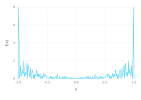

In [10]:
plot(x -> abs(legendre_poly(5, x)-P5(x))/eps(Float64),-1, 1)

Let's define a modified log base two of a relative difference `LRE`. The range of this graph appears to be about $[49,53]$. So again, we have good agreement between these functions.

In [12]:
function LRE(a,b)
    d = abs(a-b)
    if iszero(d)
        precision(a)
    elseif iszero(a)
        min(precision(a), -log2(a))
    else
        min(precision(a), -log2(abs(d/b)))
    end
end

LRE (generic function with 1 method)

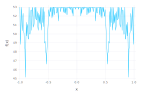

In [13]:
plot(x -> LRE(legendre_poly(5, x),P5(x)),-1, 1)

Let's test the claim that the return type is the same as the input. Here is a function that does the testing:

In [15]:
function test_types(n::Integer,x::Real, fn::Function)
    L = [Float16, Float32, Float64, BigFloat, Rational{BigInt}, 
        Complex{Float16}, Complex{Float32}, Complex{Float64}, Complex{BigFloat}, Complex{Rational{BigInt}}]
    OK = true
    for lk in L
        OK = OK && typeof(fn(n, convert(lk, x))) == lk
    end
    OK
end

test_types (generic function with 1 method)

In [16]:
test_types(0,0.23,legendre_poly), test_types(1,0.23,legendre_poly), test_types(10,0.23,legendre_poly)

(true, true, true)

The effort to compute `legendre_poly(2*n, x)` should be about twice that of `legendre_poly(n, x)`, but the difference is far greater. 

In [18]:
using BenchmarkTools

In [19]:
@btime legendre_poly(2, 0.23)

  11.011 ns (0 allocations: 0 bytes)


-0.42064999999999997

In [20]:
@btime legendre_poly(4, 0.23)

  40.827 ns (0 allocations: 0 bytes)


0.18886804374999996

In [21]:
@btime legendre_poly(8, 0.23)

  375.122 ns (0 allocations: 0 bytes)


-0.10928775530968499

In [22]:
@btime legendre_poly(16, 0.23)

  18.400 μs (0 allocations: 0 bytes)


-0.1535942313757027

A recursion for the number of floating point operations needed to compute the nth degree Legendre polynomial this way
is
$$
   C_n = C_{n-1} + C_{n-2} + 5, \quad C_0 = 0, C_1 = 1.
$$
The reason for the $+5$ is that once the recursive call has evaluated both `legendre_poly(n - 1, x)` and  `legendre_poly(n - 2, x))`, there are
five additional floating point operations needed to evaluate `((2*n - 1)*x*legendre_poly(n - 1, x) - (n - 1)*legendre_poly(n - 2, x))//n`

It's not too hard to show that an explicit formula for $C$ is 
$$
   C_k = 5 \, \mathrm{Fib}_k - 5,
$$
where $\mathrm{Fib}$ is the Fibonacci sequence. From this, it follows that $C_n \approx \sqrt{5} \times \left(\frac{1+\sqrt{5}}{2} \right)^n$, so
$C$ has exponential growth.

To make this code more efficient, we could either convert the function to be a memoizing function or write it as a purely iterative fashion. 

First, let's try a memoizing function. Julia does have a macro that converts any function into a memoizing function. There is a Julia macro that will
effortlessly convert our function into a memoizing function, but let's do it our selves (DIY).  An advantage to this DIY project is that we can delete keys that we no longer need. Doing so helps reduce the size of the dictionary (hash table). The Julia macro approach does not give us a way to delete keys that are no longer needed.

In [24]:
"""
    P(n::Integer, x::Number, dict = Dict(0 => one(x), 1 => x))::Number

    Compute the nth degree Legendre polynomial evaluated at x. The value returned has the same type as the input `x`.  
    
##### Error:

-The degree `n` must be a nonnegative integer; if not, throw an `ArgumentError`.

##### Details

-For information on Legendre polynomials, refer to DLMF Section 18.3, https://dlmf.nist.gov/18.3 . 
"""
function P(n::Integer, x::Number, dict = Dict(0 => one(x), 1 => x))::Number
    n >= 0 || throw(ArgumentError("The first argument to P must be a nonnegative integer; found $n"))
    if n in keys(dict)
        if n >= 2
            delete!(dict, n-1)
        end
        dict[n]
    else # use the Bonnet recursion
       dict[n] = ((2*n - 1)*x*P(n - 1, x,dict) - (n - 1)*P(n - 2, x,dict))/n
    end
end;

Similar to our first method, the type returned should match the type of the input. 
Does it?

In [26]:
test_types(0,0.46, P), test_types(1,0.46, P),test_types(10,0.46, P)

(true, true, true)

Let's test if our new and old versions agree. Algorithmically, these functions are the same, so a graph of the difference `P(25,x) - legendre_poly(25,x)` should be zero; it is

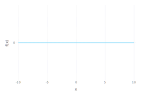

In [28]:
plot(x -> (P(5,x) - legendre_poly(5,x)),-10,10)

And let's check that the new function is more efficient. For a degree 25 Legendre polynomial, the new code is about 1,000 times faster!

In [30]:
z1 = @btime P(25,0.23)

  1.390 μs (4 allocations: 544 bytes)


-0.05702283068726503

In [31]:
z2 = @btime legendre_poly(25,0.23)

  1.404 ms (0 allocations: 0 bytes)


-0.05702283068726503

But for large orders, our memoizing function can give a stack overflow error; for example

In [33]:
P(30000,0.1)

LoadError: StackOverflowError:

In [34]:
Our next version is purely iterative. This should cure the stackoverflow problem.

LoadError: UndefVarError: `Our` not defined

In [35]:
"""
    legendre_poly(n::Integer, x::Number)::Number

Compute the nth degree Legendre polynomial evaluated at `x`. Unless the input `x` is an integer or a complex integer, the return value has the same 
type as the input `x`. When the input `x` is an integer or a complex integer, the number `x` is promoted to a rational type.

##### Error:

-The degree `n` must be a nonnegative integer; if not, throw an `ArgumentError`.

##### Details

-For information on Legendre polynomials, refer to DLMF Section 18.3, https://dlmf.nist.gov/18.3 . 
"""
function legendre_poly(n::Integer, x::Number)::Number
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be a nonnegative integer; found $n"))
    p0 = one(x)
    if n == 0 
        one(x)
    else
        p1 = x
        for k in 2:n # use the Bonnet recursion
            (p0,p1) = (p1, ((2*k - 1)*x*p1 - (k - 1)*p0)//k)
        end
        p1
    end
end;

Let's compare speeds. The purely iterative method is about ten times faster for a 1,000 degree polynomial.

In [37]:
z1 = @btime P(10^3,0.23)

  67.400 μs (40 allocations: 5.97 KiB)


0.02454507368238845

In [38]:
z2 = @btime legendre_poly(10^3,0.23)

  7.025 μs (0 allocations: 0 bytes)


0.02454507368238845

Let's compare the explicit formula for the 5th order Legendre polynomial to the new code.


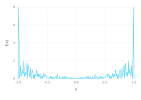

In [40]:
plot(x -> abs(legendre_poly(5, x)-P5(x))/eps(Float64),-1, 1)

The claim is that except for integer inputs, the type of the output is the same as the input `x`. This passes some simple tests:

In [42]:
test_types(0,0.128,legendre_poly),test_types(1,0.128,legendre_poly),test_types(28,0.128,legendre_poly)

(true, true, true)

Unfortunately, for large degree, the code can overflow, and subtraction in `(p1, ((2*k - 1)*x*p1 - (k - 1)*p0) / k)` gives `NaN`. An example

In [44]:
xBig = legendre_poly(5000, -1.018)

NaN

Possibly the code should monitor for an overflow and bailout when that happens. Another possibility is to require that the input be in the interval $[-1,1]$, then overflow will not happen.

To avoid this overflow, we can use BigFloat numbers. Here we see that the value exceeds the largest `Float64` number. A better value for 
`legendre_poly(5000, -1.018)` is `Inf` not `NaN`.

In [46]:
legendre_poly(5000, BigFloat(-1.018))

3.507125816773159960579868905776330855360801710615406803241746151525299693053747e+409

What about accuracy? Should we trust every digit? Of course not. Here is an example where the last five digits of a Float64 value are not correct. To find the exact value, we use rational arithmetic to find the value.

In [48]:
xFloat64 = legendre_poly(5000, -63/64)

-0.0004553305753125159

In [49]:
xBig = convert(Float64, legendre_poly(5000, BigInt(-63)//64))

-0.0004553305753136357

The relative difference is about $10^{-12}$.

In [51]:
(xFloat64 - xBig)/xBig

-2.4593521159441414e-12

What's the story? The subtraction in ` ((2*k - 1)*x*p1 - (k - 1)*p0) / k)` can be ill-conditioned. 

The Legendre polynomials are so useful, there is a standard Julia package for them.  Let's try some comparisons

In [53]:
using LegendrePolynomials

In [54]:
? Pl

search: Pl Plm Plot plot split splat splice! splitext splitdir splitpath



```
Pl(x, l::Integer; [norm = Val(:standard)])
```

Compute the Legendre Polynomial $P_\ell(x)$ for the argument `x` and the degree `l`.

The default norm is chosen to be `Val(:standard)`, in which case the polynomials satisfy `Pl(1, l) == 1` for all `l`. Optionally, the `norm` may be set to `Val(:normalized)` to obtain normalized Legendre polynomials. These have an L2 norm of `1`.

# Examples

```jldoctest
julia> Pl(1, 2)
1.0

julia> Pl(0.5, 4) ≈ -37/128 # analytically obtained value
true

julia> Pl(0.5, 20, norm = Val(:normalized))
-0.21895188261094017
```


A graph of there difference shows that the outputs are so similar, they must use the same algorithm.

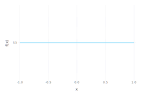

In [56]:
plot([x -> LRE(legendre_poly(500, x) , Pl(x,500))],-1,1)

There are differences; the function `Pl` returns a BigFloat result when the input is a rational

In [58]:
Pl(BigInt(57)//63,500)

0.04823192143675528282987754393801954779693187455698170870172105574745082164621903

Another difference is that `Pl` seems to throw an argument error when the input isn't in the interval $[-1,1]$. The user documentation doesn't say anything about that or about the return type

In [60]:
Pl(10.23, 8)

LoadError: DomainError with 10.23:
Legendre Polynomials are defined for arguments lying in -1 ⩽ x ⩽ 1

But contrary to the error message `Legendre Polynomials are defined for arguments lying in -1 ⩽ x ⩽ 1`. I would call that a bug.

In [62]:
Pl(0.23+ 0.1*im, 8)

-0.14641219999992097 - 0.25393938537575345im

For $n \to \infty$, asymptotically the leading terms of the solution to the Bonnet recursion are
$$
   \left(x \pm \sqrt{x^2+1} \right)^n / \sqrt{n}.
$$
Further, the leading term of the $n \to \infty$ asymptotic behavior of $P_n(x)$ is $\left(x + \sqrt{x^2+1} \right)^n / \sqrt{n}$. So when
$$
    |\left(x +  \sqrt{x^2+1} \right)^n / \sqrt{n}| < |\left(x -  \sqrt{x^2+1} \right)^n / \sqrt{n}|, 
$$
the recursion is unstable. Fortunately, for $x \in [-1,1]$, the instability is modest. We'll show this graphically.

In [64]:
function stable_cnd(z)
    c1 = abs(z - sqrt(z^2+1))
    c2 = abs(z + sqrt(z^2+1))
    if c2 <= c1  c1/c2 else 0 end
end

stable_cnd (generic function with 1 method)

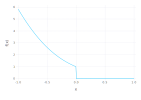

In [65]:
plot(x -> stable_cnd(x), -1,1)

For $\mathrm{Re}(x) << 0$, the recursion is unstable

Here is a look at the stability condition in the complex plane. The recursion is unstable for $\mathrm{Re} (z) \ll 0$. But I think this is a bit difficult to observe because on this region, numerical evaluation often overflows.

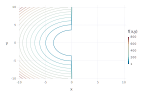

In [68]:
plot((x,y) -> stable_cnd(x+y*im),-10,10,-10,10)

To test the accuracy of our code, let's compare values found using floating point evaluation and exact rational evaluation.

In [70]:
function accuracy_test(n,x)
    y1 = legendre_poly(n, x)
    y2 = legendre_poly(n, convert(Rational{BigInt},x))    
    LRE(y1,y2)    
end

accuracy_test (generic function with 1 method)

A graph shows that the accuracy for degree 100 in the interval $[-1,1]$ is good.

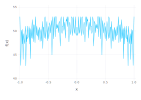

In [72]:
plot(x ->  accuracy_test(100, convert(Float64,x)),-1,1)

For large degree, outside the interval, we mostly get overflow errors. Let's look at the accuracy of degree 1000 polynomials in the interval $[-1,1]$.

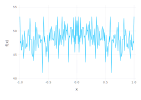

In [74]:
plot(x ->  accuracy_test(10^3, convert(Float64, x)),-1,1)

For the Bonnet recursion, what is the worst addition condition number? 

In [76]:
function add_cnd(a::Real,b::Real)
  (abs(a)+abs(b))/abs(a+b)
end

add_cnd (generic function with 1 method)

In [77]:
function add_cnd(a::Complex,b::Complex)
  max(add_cnd(real(a), real(b)), add_cnd(imag(a),imag(b)))
end

add_cnd (generic function with 2 methods)

In [78]:
function legendre_poly_cnd(n::Integer, x::Number)
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be a nonnegative integer; found $n"))
    worst = -Inf
    p0 = one(x)
    if n == 0 
        one(x)
    else
        p1 = x
        for k in 2:n # use the Bonnet recursion                
            (p0,p1) = (p1, ((2*k - 1)*x*p1 - (k - 1)*p0)//k)
            worst = max(worst, add_cnd((2*k - 1)*x*p1, - (k - 1)*p0))
        end
        worst
    end
end;

A graph of the worst condition number shows some largish spikes for degree 10.

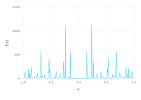

In [80]:
plot(x -> legendre_poly_cnd(10,x),-1,1)

https://etna.math.kent.edu/vol.54.2021/pp323-332.dir/pp323-332.pdf

Here is a method that evaluates the Legendre polynomial using a power series in `(x-1)/2`.  The sum is
$$
  P_n(x)= \sum_{k=0}^n \binom{n}{k} \binom{n+k}{k} \left( \frac{x-1}{2} \right)^{\!k}.
$$
This can be summed from high to low power or from low to high power.

In [82]:
function LP_high_to_low(n::Integer, x::Number)
    w = (x-1)/2
    uno = one(x)
    s = uno
    for k in n : -1 :  1
        c = ((n-k+1)*(n+k))//k^2
        s = uno + c*w*s
    end
    s
end;         

In [83]:
function LP_low_to_high(n::Integer, x::Number)       
    w = (x-1)/2
    s = zero(x)
    z = one(x)
    ck = one(x)
    for k in 0 : n   
       s += ck*z
       ck *= (n-k)*(n+k+1)/(k+1)^2
       z *= w
    end
    s
end;  

Even for a modest degree and near 1, these methods differ by a fair amount.

In [85]:
LP_low_to_high(25, 0.75),LP_high_to_low(25, 0.75), legendre_poly(25, 0.75)

(0.06842766647710583, 0.06842766655582011, 0.0684276664756836)

But for inputs near -1, watch out! These methods disagree by a large amount!

In [87]:
LP_low_to_high(25, -0.75),LP_high_to_low(25, -0.75), legendre_poly(25, -0.75)

(5.9462890625, 4.04428214325455, -0.0684276664756836)

Let's look at the accuracy of this new method.  For degree 25, the accuracy is good for $x > 1$ and poor for inputs near -1. 

In [89]:
function accuracy_test_high_to_low(n,x)
    y1 = LP_high_to_low(n, x)
    y2 = legendre_poly(n, convert(Rational{BigInt},x))    
    LRE(y1,y2)    
end

accuracy_test_high_to_low (generic function with 1 method)

In [90]:
function accuracy_test_low_to_high(n,x)
    y1 = LP_low_to_high(n, x)
    y2 = legendre_poly(n, convert(Rational{BigInt},x))    
    LRE(y1,y2)    
end

accuracy_test_low_to_high (generic function with 1 method)

The two methods give similar accuracies. Both methods are inaccurate near -1.

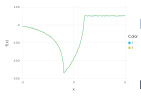

In [92]:
plot([x -> accuracy_test_high_to_low(128,x), x -> accuracy_test_low_to_high(128,x)],-5,5)

Why the inaccuracy? It's the result of an ill-conditioned sum. The only cures to an ill-conditioned sum are

- use a different algorithm
- use higher precision numbers

Compensated addition might help slightly, but it is _not_ a cure for an ill-conditioned sum.  Here we explicitly find the worst sum condition number and return it along with the sum.

In [94]:
function LP_low_to_high(n::Integer, x::Number)       
    w = (x-1)/2
    s = zero(x)
    z = one(x)
    ck = one(x)
    cnd = -Inf
    for k in 0 : n   
       cnd = max(cnd, (abs(s) + abs(ck*z))/abs(s+ck*z))
       s = s + ck*z
       ck *= (n-k)*(n+k+1)/(k+1)^2
       z *= w
    end
    s,cnd
end;

Here is a graph of the common log of the largest sum condition number on the interval $[-1,1]$.

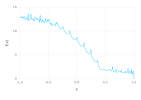

In [96]:
plot(x -> log10(LP_low_to_high(25,x)[2]), -1,1)

Amusingly, for higher degrees, the worst sum condition number is not so terrible

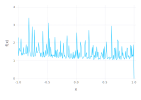

In [98]:
plot(x -> log10(LP_low_to_high(150,x)[2]), -1,1)

Another sum for the Legendre polynomials is
$$
   P_n(x)= \frac{1}{2^n} \sum_{k=0}^n \binom{n}{k}^{\!2} (x-1)^{n-k}(x+1)^k
$$
Possibly we could gain a bit of accuracy by using `fma` inside the loop. But that will fail for the complex case.

In [100]:
function legendre_poly_2(n::Integer, x::Number)
    w = (x+1)/(x-1)
    uno = one(x)
    s = uno
    for k in n : -1 : 1
        c = (n-k+1)/k
        s = uno + c^2*w*s
    end
    s * ((x-1)/2)^n
end;

In [101]:
function accuracy_test_2(n,x)
    y1 = legendre_poly_2(n, x)
    y2 = legendre_poly(n, convert(Rational{BigInt},x))    
    LRE(y1,y2)    
end

accuracy_test_2 (generic function with 1 method)

This method is accurate away from $[-1,1]$ and poor in the interval $[-1,1]$.

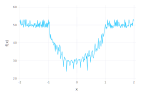

In [103]:
plot(x -> accuracy_test_2(25,x),-2,2)

Finally, let's try a version of interval arithmetic.  There are several standard Julia packages that do interval arithmetic, but let's try writing our own code. 

Specifically, let us define $x  \in \mathrm{ball}(a,r)  \equiv |x - a| \leq \varepsilon r$, where $\varepsilon$ is the machine epsilon.  So
$x \in \mathrm{ball}(a,r_a)$ and $y \in \mathrm{ball}(b,r_b)$ implies $xy \in \mathrm{ball}(ab, |b| r_a + |a| r_b + \varepsilon r_a r_b)$. 
And for floating point multiplication $\otimes$, we have $x \otimes y \in \mathrm{ball}(ab, |ab| + |b| r_a + |a| r_b + \varepsilon r_a r_b)$.

For addition, we have $x \in \mathrm{ball}(a,r_a)$ and $y \in \mathrm{ball}(b,r_b)$ implies $x + y \in \mathrm{ball} 
\left (a+b, r_a + r_b \right)$. And for floating point addition $\oplus$, we have $ x \oplus y \in \mathrm{ball} \left (a+b, r_a + r_b + |x + y| \right)$.

In [105]:
struct ball{T<:Number}
    c::T
    r::T
      
    function ball(c::T, r::Number) where T<:Number
        new{T}(c, r)
    end

    function ball(c::T) where T<:Number
        new{T}(c, zero(c))
    end
end

In [106]:
function negate(x::ball)
    ball(-x.c, x.r)
end;

In [107]:
import Base: +, -, *, /

function *(x::ball{T}, y::ball{T}) where T<:AbstractFloat
   z = x.c * y.c
   ball(z, abs(z) + abs(x.c) * y.r + abs(y.c) * x.r)
end

function *(x::Number, y::ball{T}) where T<:AbstractFloat
      ball(convert(T,x)) * y
end

function *(x::ball{T}, y::Number) where T<:AbstractFloat
      x * ball(convert(T,y))
end

function +(x::ball{T}, y::ball{T}) where T<:AbstractFloat
    z = x.c + y.c
     ball(z, x.r + y.r + abs(z))
end

function +(x::Number, y::ball{T}) where T<:AbstractFloat
    ball(convert(T,x))+y
end
    
function +(x::ball{T}, y::Number) where T<:AbstractFloat
    x + ball(convert(T,y))
end

function -(x::ball{T}, y::ball{T}) where T<:AbstractFloat
  x + negate(y)
end
        
function -(x::ball{T}, y::Number) where T<:AbstractFloat
  x - ball(convert(T,y))
end
        
function -(x::Number, y::ball{T}) where T<:AbstractFloat
  ball(convert(T,x)) - y
end        

function /(x::ball{T}, y::ball{T}) where T<:AbstractFloat
    ball(x.c/y.c, (abs(y.c) * x.r + abs(x.c) * y.r) / (y.c)^2)
end

function /(x::ball{T}, y::Number) where T<:AbstractFloat
    x / ball(convert(T,y))
end
        
function /(x::Number, y::ball{T}) where T<:AbstractFloat
    ball(convert(T,x))/y
end

/ (generic function with 175 methods)

In [108]:
function LP(n::Integer, x::Number)
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be nonnegative; found $n"))
    
    p0 = ball(one(x))
    if n == 0 
        p0
    else
        p1 = ball(x)
        for k in 2:n # use the Bonnet recursion
             (p0,p1) = (p1, ((2*k - 1)*x*p1 - (k - 1)*p0)/k)
         end
       p1
    end
end

LP (generic function with 1 method)

Generally, the error is highly pessimistic, and it grows rather fast with the degree.

In [110]:
LP(2, 0.9)

ball{Float64}(0.7150000000000001, 2.43)

In [111]:
LP(4, 0.9)

ball{Float64}(0.2079375, 12.430125)

In [112]:
LP(8, 0.9)

ball{Float64}(-0.40968590351562517, 235.2249782120536)

In [113]:
LP(16, 0.9)

ball{Float64}(0.27833870133758787, 108942.1733905613)

In [114]:
LP(32, 0.9)

ball{Float64}(0.05695794106848601, 3.2325172447180775e10)

Herbie is an online tool that suggest alternative ways to numerically evaluate an expression to gain the best accuracy. For input, Herbie requires a range for each of the variables in the expression. For the ranges I choose, for the expression `((2*k - 1)*x*p1 - (k - 1)*p0)/k`,  Herbie suggested that `(((p1 * x) * 2.0) - ((p1 * x) / k)) + ((p0 / k) - p0)` was slightly more accurate.  Here is a "Herbie improved" method

In [470]:
function legendre_polyHerbie(n::Integer, x::Number)::Number
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be a nonnegative integer; found $n"))
    p0 = one(x)
    if n == 0 
        one(x)
    else
        p1 = x
        for k in 2:n # use the Bonnet recursion
            (p0,p1) = (p1, (((p1 * x) * 2) - ((p1 * x) / k)) + ((p0 / k) - p0))
        end
        p1
    end
end;

In [489]:
(n,x) = (500, 1.8)

(500, 1.8)

In [491]:
(y1, y2, ye) = legendre_poly(n,x),legendre_polyHerbie(n,x), convert(Float64, legendre_poly(n, convert(Rational{BigInt}, x)))

(2.884614138836599e257, 2.884614138836587e257, 2.884614138836581e257)

In [493]:
LRE(y1,ye)

47.176435894099754

In [495]:
LRE(y2,ye)

48.80446711671279

In [497]:
(8, -1.08)

(8, -1.08)

In [499]:
(y1, y2, ye) = legendre_poly(n,x),legendre_polyHerbie(n,x), convert(Float64, legendre_poly(n, convert(Rational{BigInt}, x)))

(2.884614138836599e257, 2.884614138836587e257, 2.884614138836581e257)

In [501]:
LRE(y1,ye)

47.176435894099754

In [503]:
LRE(y2,ye)

48.80446711671279